### Imports

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import lang2vec.lang2vec as l2v
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import chi2_contingency
from datetime import datetime

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',None)
NFOLDS = 10
SEED = 7

### Set arguments

At a later stage the parameters below can become argparse parameters

In [3]:
overwrite_chi2 = False
remove_correlated = False
encoding = "onehot"
use_syn_dist=True
remove_weird_pairs = True
is_same = False
selection = "all"

### Load data

#### Load table with language features

In [4]:
lang_feats = pd.read_excel("../../xtreme_langs_wals.xlsx", index_col=0)

In [5]:
lang_feats.head()

,ISO 693-2,wals_code,iso_code,glottocode,Name,latitude,longitude,genus,family,#feats,macroarea,countrycodes,20A Fusion of Selected Inflectional Formatives,21A Exponence of Selected Inflectional Formatives,22A Inflectional Synthesis of the Verb,23A Locus of Marking in the Clause,24A Locus of Marking in Possessive Noun Phrases,25A Locus of Marking: Whole-language Typology,26A Prefixing vs. Suffixing in Inflectional Morphology,27A Reduplication,28A Case Syncretism,29A Syncretism in Verbal Person/Number Marking,30A Number of Genders,31A Sex-based and Non-sex-based Gender Systems,32A Systems of Gender Assignment,33A Coding of Nominal Plurality,34A Occurrence of Nominal Plurality,35A Plurality in Independent Personal Pronouns,36A The Associative Plural,37A Definite Articles,38A Indefinite Articles,39A Inclusive/Exclusive Distinction in Independent Pronouns,40A Inclusive/Exclusive Distinction in Verbal Inflection,41A Distance Contrasts in Demonstratives,42A Pronominal and Adnominal Demonstratives,43A Third Person Pronouns and Demonstratives,44A Gender Distinctions in Independent Personal Pronouns,45A Politeness Distinctions in Pronouns,46A Indefinite Pronouns,47A Intensifiers and Reflexive Pronouns,48A Person Marking on Adpositions,49A Number of Cases,50A Asymmetrical Case-Marking,51A Position of Case Affixes,52A Comitatives and Instrumentals,53A Ordinal Numerals,54A Distributive Numerals,55A Numeral Classifiers,56A Conjunctions and Universal Quantifiers,57A Position of Pronominal Possessive Affixes,58A Obligatory Possessive Inflection,59A Possessive Classification,"60A Genitives, Adjectives and Relative Clauses",61A Adjectives without Nouns,62A Action Nominal Constructions,63A Noun Phrase Conjunction,64A Nominal and Verbal Conjunction,65A Perfective/Imperfective Aspect,66A The Past Tense,67A The Future Tense,68A The Perfect,69A Position of Tense-Aspect Affixes,70A The Morphological Imperative,71A The Prohibitive,72A Imperative-Hortative Systems,73A The Optative,74A Situational Possibility,75A Epistemic Possibility,76A Overlap between Situational and Epistemic Modal Marking,77A Semantic Distinctions of Evidentiality,78A Coding of Evidentiality,79A Suppletion According to Tense and Aspect,80A Verbal Number and Suppletion,"81A Order of Subject, Object and Verb",82A Order of Subject and Verb,83A Order of Object and Verb,"84A Order of Object, Oblique, and Verb",85A Order of Adposition and Noun Phrase,86A Order of Genitive and Noun,87A Order of Adjective and Noun,88A Order of Demonstrative and Noun,89A Order of Numeral and Noun,90A Order of Relative Clause and Noun,91A Order of Degree Word and Adjective,92A Position of Polar Question Particles,93A Position of Interrogative Phrases in Content Questions,94A Order of Adverbial Subordinator and Clause,95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase,96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun,97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun,98A Alignment of Case Marking of Full Noun Phrases,99A Alignment of Case Marking of Pronouns,100A Alignment of Verbal Person Marking,101A Expression of Pronominal Subjects,102A Verbal Person Marking,103A Third Person Zero of Verbal Person Marking,104A Order of Person Markers on the Verb,105A Ditransitive Constructions: The Verb 'Give',106A Reciprocal Constructions,107A Passive Constructions,108A Antipassive Constructions,109A Applicative Constructions,110A Periphrastic Causative Constructions,111A Nonperiphrastic Causative Constructions,112A Negative Morphemes,113A Symmetric and Asymmetric Standard Negation,114A Subtypes of Asymmetric Standard Negation,115A Negative Indefinite Pronouns and Predicate Negation,116A Polar Questions,117A Predicative Possession,118A Predicative Adjectives,119A Nominal and Locational Predication,120A Zero Copula for Predicate Nominals,121A Comparative Constructions,122A Relativization on S

In [6]:
lang_feats.shape

(40, 185)

Display unique values of selected features

#### Load language pairs with scores

In [7]:
pair_scores = pd.read_csv("ner_lang_pair_scores.csv")

In [8]:
pair_scores.head()

,train_lang,test_lang,acc,f1
0,af,af,0.978337,0.913753
1,af,ar,0.793688,0.546847
2,af,bg,0.903963,0.766965
3,af,bn,0.709012,0.561632
4,af,de,0.921272,0.731704


In [9]:
feat_cols = lang_feats.dropna(axis=1,how='all').columns[12:]

### Prepare dataset

Prepare a dataset for training a model to predict accuracy of a language pair

In [10]:
final_arr = []


if is_same:
    for i in pair_scores.index:
        train_lang = pair_scores.at[i,"train_lang"]
        test_lang = pair_scores.at[i,"test_lang"]
        
        switched_acc = pair_scores[(pair_scores.train_lang==test_lang)&(pair_scores.test_lang==train_lang)].acc.values[0]
        avg_acc = (switched_acc+pair_scores.at[i,"acc"])/2
        
        switched_f1 = pair_scores[(pair_scores.train_lang==test_lang)&(pair_scores.test_lang==train_lang)].f1.values[0]
        avg_f1 = (switched_acc+pair_scores.at[i,"f1"])/2
        
        train_feats = [train_lang, test_lang,avg_acc, avg_f1] + list((lang_feats.loc[train_lang,feat_cols]==lang_feats.loc[test_lang,feat_cols]).values)
        final_arr.append(train_feats)
        
    feat_cols = ["is_"+col.split()[0]+"_same" for col in feat_cols]
else:
    for i in pair_scores.index:
        train_lang = pair_scores.at[i,"train_lang"]
        test_lang = pair_scores.at[i,"test_lang"]
        train_feats =  list(pair_scores.iloc[i,:].values) + list(lang_feats.loc[train_lang,feat_cols].values) + list(lang_feats.loc[test_lang,feat_cols].values)
        final_arr.append(train_feats)
        
    feat_cols = [col.split()[0]+"_train" for col in feat_cols]+ [col.split()[0]+"_test" for col in feat_cols]
    
final_cols = list(pair_scores.columns)+feat_cols

final_df = pd.DataFrame(data=final_arr,columns=final_cols)

In [11]:
final_df = final_df.drop_duplicates(subset='acc')

Remove languages that are not in UD POS for better comparison

In [12]:
final_df = final_df[~(final_df.train_lang.isin(['bn', 'jv', 'ka', 'ml', 'ms', 'my', 'sw']))& ~(final_df.test_lang.isin(['bn', 'jv', 'ka', 'ml', 'ms', 'my', 'sw']))]

In [13]:
final_df.head()

,train_lang,test_lang,acc,f1,20A_train,21A_train,22A_train,23A_train,24A_train,25A_train,26A_train,27A_train,28A_train,29A_train,30A_train,31A_train,32A_train,33A_train,34A_train,35A_train,36A_train,37A_train,38A_train,39A_train,40A_train,41A_train,42A_train,43A_train,44A_train,45A_train,46A_train,47A_train,48A_train,49A_train,50A_train,51A_train,52A_train,53A_train,54A_train,55A_train,56A_train,57A_train,58A_train,59A_train,60A_train,61A_train,62A_train,63A_train,64A_train,65A_train,66A_train,67A_train,68A_train,69A_train,70A_train,71A_train,72A_train,73A_train,74A_train,75A_train,76A_train,77A_train,78A_train,79A_train,80A_train,81A_train,82A_train,83A_train,84A_train,85A_train,86A_train,87A_train,88A_train,89A_train,90A_train,91A_train,92A_train,93A_train,94A_train,95A_train,96A_train,97A_train,98A_train,99A_train,100A_train,101A_train,102A_train,103A_train,104A_train,105A_train,106A_train,107A_train,108A_train,109A_train,110A_train,111A_train,112A_train,113A_train,114A_train,115A_train,116A_train,117A_train,118A_train,119A_train,120A_train,121A_train,122A_train,123A_train,124A_train,125A_train,126A_train,127A_train,128A_train,129A_train,130A_train,131A_train,132A_train,133A_train,134A_train,135A_train,136A_train,137A_train,138A_train,142A_train,143F_train,90B_train,90C_train,144P_train,144J_train,144N_train,144S_train,144X_train,144A_train,90E_train,144V_train,144I_train,144R_train,143B_train,144M_train,144G_train,144K_train,144B_train,90D_train,144E_train,144D_train,81B_train,143E_train,143C_train,143A_train,144W_train,144Q_train,144L_train,144H_train,144C_train,144T_train,143G_train,137B_train,136B_train,109B_train,25B_train,21B_train,108B_train,58B_train,79B_train,20A_test,21A_test,22A_test,23A_test,24A_test,25A_test,26A_test,27A_test,28A_test,29A_test,30A_test,31A_test,32A_test,33A_test,34A_test,35A_test,36A_test,37A_test,38A_test,39A_test,40A_test,41A_test,42A_test,43A_test,44A_test,45A_test,46A_test,47A_test,48A_test,49A_test,50A_test,51A_test,52A_test,53A_test,54A_test,55A_test,56A_test,57A_test,58A_test,59A_test,60A_test,61A_test,62A_test,63A_test,64A_test,65A_test,66A_test,67A_test,68A_test,69A_test,70A_test,71A_test,72A_test,73A_test,74A_test,75A_test,76A_test,77A_test,78A_test,79A_test,80A_test,81A_test,82A_test,83A_test,84A_test,85A_test,86A_test,87A_test,88A_test,89A_test,90A_test,91A_test,92A_test,93A_test,94A_test,95A_test,96A_test,97A_test,98A_test,99A_test,100A_test,101A_test,102A_test,103A_test,104A_test,105A_test,106A_test,107A_test,108A_test,109A_test,110A_test,111A_test,112A_test,113A_test,114A_test,115A_test,116A_test,117A_test,118A_test,119A_test,120A_test,121A_test,122A_test,123A_test,124A_test,125A_test,126A_test,127A_test,128A_test,129A_test,130A_test,131A_test,132A_test,133A_test,134A_test,135A_test,136A_test,137A_test,138A_test,142A_test,143F_test,90B_test,90C_test,144P_test,144J_test,144N_test,144S_test,144X_test,144A_test,90E_test,144V_test,144I_test,144R_test,143B_test,144M_test,144G_test,144K_test,144B_test,90D_test,144E_test,144D_test,81B_test,143E_test,143C_test,143A_test,144W_test,144Q_test,144L_test,144H_test,144C_test,144T_test,143G_test,137B_test,136B_test,109B_test,25B_test,21B_test,108B_test,58B_test,79B_test
0,af,af,0.978337,0.913753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 Unique periphrastic associative plural,NaN,NaN,NaN,NaN,2 Two-way contrast,1 Identical,NaN,NaN,NaN,NaN,1 Identical,NaN,NaN,NaN,NaN,1 Identity,"6 First, two-th, three-th",1 No distributive numerals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 No grammatical marking,"1 Present, no remoteness distinctions",2 No inflectional future,"2 From 'finish', 'already'",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Indirect only,4 Separate particle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Different,2 Different,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Words derived from M

Keep only zero-shot learning pairs

In [14]:
final_df = final_df[final_df['train_lang']!=final_df['test_lang']]

### Kruskal correlation between target and every feature per lang

In [15]:
import scipy.stats as stats
def kruskal_per_lang(x):
    kruskal = {"test_lang":[],"feature":[],"h":[],"p":[],"result":[]}
    alpha = 0.05
    test_feats = [col for col in x.columns if "_train" in col]
    assert len(test_feats)>0,"Set is_same to False"
    test_lang = x.iat[0,1]
    for col in test_feats:
        col_df = x[[col,'acc']].dropna()
        if col_df[col].nunique()>1:
            groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
            h, p = stats.kruskal(*groups)
            if p<alpha:
                result = 'Dependent (reject H0)'
            else:
                result = 'Independent (fail to reject H0)'
            kruskal["test_lang"].append(test_lang)
            kruskal['feature'].append(col)
            kruskal['h'].append(h)
            kruskal['p'].append(p)
            kruskal['result'].append(result)
    
    kruskal = pd.DataFrame.from_dict(kruskal)
    return kruskal

kruskal_test = final_df.groupby(by="test_lang").apply(kruskal_per_lang).reset_index(drop=True)
min_p_ixs = kruskal_test.groupby(by='test_lang').p.idxmin()
most_corr_per_lang = kruskal_test.loc[min_p_ixs,:]
most_corr_per_lang

,test_lang,feature,h,p,result
98,af,121A_train,8.735526,0.012680,Dependent (reject H0)
231,ar,119A_train,6.349206,0.011743,Dependent (reject H0)
304,bg,53A_train,12.913818,0.011705,Dependent (reject H0)
517,de,138A_train,11.009524,0.000906,Dependent (reject H0)
575,el,52A_train,7.697455,0.021307,Dependent (reject H0)
693,en,37A_train,12.478095,0.014129,Dependent (reject H0)
920,es,138A_train,6.192857,0.012827,Dependent (reject H0)
1044,et,121A_train,10.425794,0.005446,Dependent (reject H0)
1086,eu,24A_train,8.226475,0.083626,Independent (fail to reject H0)
1348,fa,21B_train,9.080972,0.010668,Dependent (reject H0)


In [16]:
import seaborn as sns

def plot_most_corr(x):
    test_lang = x.iat[0,0]
    most_corr_feat = x.iat[0,1]
    ax = sns.barplot(x=most_corr_feat, y="acc", data=final_df[final_df.test_lang==test_lang])
    plt.title("Most correlated feature for {}".format(test_lang))
    plt.xticks(rotation=30)
    plt.ylim([0,1])
    plt.show()
    
kpl = True
if kpl:    
#     most_corr_per_lang.groupby(by="test_lang").apply(plot_most_corr)

    def output(x):
        print("Feature",x.iat[0,1])
        print("Langs",x.test_lang.unique())
        
    most_corr_per_lang.groupby(by="feature").apply(output)
    most_corr_per_lang['feature'].value_counts()

Feature 103A_train
Langs ['ur']
Feature 112A_train
Langs ['fi']
Feature 115A_train
Langs ['tl']
Feature 119A_train
Langs ['ar']
Feature 121A_train
Langs ['af' 'et' 'hu' 'it' 'ru']
Feature 138A_train
Langs ['de' 'es' 'nl' 'pt' 'yo']
Feature 21B_train
Langs ['fa']
Feature 24A_train
Langs ['eu']
Feature 25A_train
Langs ['kk']
Feature 37A_train
Langs ['en' 'ta' 'tr' 'vi']
Feature 51A_train
Langs ['te']
Feature 52A_train
Langs ['el']
Feature 53A_train
Langs ['bg' 'id']
Feature 63A_train
Langs ['hi']
Feature 64A_train
Langs ['fr']
Feature 66A_train
Langs ['he' 'mr']
Feature 72A_train
Langs ['ko']
Feature 83A_train
Langs ['zh']
Feature 93A_train
Langs ['ja' 'th']


In [17]:
if kpl: 
#     show most important features aggregated for all langauges 
    kruskal_per_lang(final_df).drop(["test_lang"],axis=1).sort_values(by='p').head()

### Kruskal feature selection

In [18]:
if selection=="kruskal":
    alpha = 0.05
    dep_cols = []
    for col in feat_cols:
        col_df = final_df[[col,'acc']].dropna()
        if col_df[col].nunique()>1:
            groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
            if stats.kruskal(*groups).pvalue<alpha:
                dep_cols.append(col)

Delete features that have only missing values

### Add syntactical distance

We are using ISO 369-2 and lang2vec is using ISO 369-3, but they mostly overlap. For UD POS only Malay does not have a precomputed distance (its ISO 369-1 is "ms", ISO 369-2 is "may" and ISO 369-3 is "mly"). Therefore we delete it from the list to avoid errors.

In [19]:
if use_syn_dist:
    lang_codes_2 = list(lang_feats['ISO 693-2'].values)
    lang_codes_2.remove("may")
    lang_codes_1 = list(lang_feats.index)
    lang_codes_1.remove("ms")
    synt_dist = pd.DataFrame(data=l2v.syntactic_distance(lang_codes_2),index=lang_codes_1,columns=lang_codes_1)

    for i in final_df.index:
        train_lang = final_df.at[i,"train_lang"]
        test_lang = final_df.at[i,"test_lang"]
        try:
            final_df.at[i,"syn_dist"] =  synt_dist.at[train_lang, test_lang]
        except:
            print("Language not in URIEL")
    #       TODO: for now just add a place holder for languages that are not in the URIEL database
            final_df.at[i,"syn_dist"] = -1

### Other preprocessing

#### Remove French test pairs, German-English pair and all Chinese and Japanese pairs

In [20]:
if remove_weird_pairs:
    removed_pairs = (final_df.train_lang.isin(['ja','zh'])) | (final_df.test_lang.isin(['ja','zh']))
    final_df = final_df[~removed_pairs]

In [21]:
final_df = final_df.dropna(axis=1,how='all')

In [22]:
lang_feats.columns

Index(['ISO 693-2', 'wals_code', 'iso_code', 'glottocode', 'Name', 'latitude',
       'longitude', 'genus', 'family', '#feats',
       ...
       '137B M in Second Person Singular', '136B M in First Person Singular',
       '109B Other Roles of Applied Objects',
       '10B Nasal Vowels in West Africa',
       '25B Zero Marking of A and P Arguments',
       '21B Exponence of Tense-Aspect-Mood Inflection',
       '108B Productivity of the Antipassive Construction',
       '130B Cultural Categories of Languages with Identity of 'Finger' and 'Hand'',
       '58B Number of Possessive Nouns',
       '79B Suppletion in Imperatives and Hortatives'],
      dtype='object', length=185)

### Fill missing values

In [23]:
cat_cols = list(final_df.select_dtypes(include=['object']).columns)

In [24]:
final_df[cat_cols] = final_df[cat_cols].fillna("0 Missing")

In [25]:
final_df.isna().any().any()

False

### Encode categorical variables (i.e. all of them)

In [26]:
if encoding=="ordinal":
    mappings = []
    for col in cat_cols:
        unique_vals = final_df[col].unique()
    #     every value starts with an index number, additionally we mark missing as 0
        sorted_vals = sorted(unique_vals, key=lambda element: [element[0]])
        mappings.append(sorted_vals)

    oe = OrdinalEncoder(categories=mappings)
    oe.fit(final_df[cat_cols])
    final_df[cat_cols] = oe.transform(final_df[cat_cols])
elif encoding=="onehot":
    from sklearn.preprocessing import OneHotEncoder

    one_hot = pd.get_dummies(final_df[cat_cols])
    final_df = final_df.drop(cat_cols,axis=1)
    final_df = pd.concat([final_df,one_hot],axis=1)
    
    cols_with_brackets = [col for col in final_df.columns if '[' in col ]
    brackets_dict = {}
    for col in cols_with_brackets:
        brackets_dict[col] = re.sub("\[|\]", "", col) # remove square brackets
    final_df = final_df.rename(columns=brackets_dict)
else:
    raise Exception("Incorrect encoding name. Choose between \"ordinal\" and \"onehot\"")

### Functions for training and evaluation

In [27]:
def fold_metrics(model, x_train, y_train, x_val, y_val, metrics_dict,debug=False): 
    y_preds = model.predict(x_train)
    fold_train = np.sqrt(mean_squared_error(y_train,y_preds))
    
    y_preds_val = model.predict(x_val)
    fold_val = np.sqrt(mean_squared_error(y_val,y_preds_val))


    
    metrics_dict['train']['rmse'].append(fold_train)
    metrics_dict['test']['rmse'].append(fold_val)
    
    if debug:
        metrics = pd.DataFrame.from_dict({'train':[fold_train],
                                         'test':[fold_val]})
        metrics.index = ['rmse']
        display(metrics)

In [28]:
def mean_fold_metrics(metrics_dict):
    
    train_rmse = np.mean(metrics_dict['train']['rmse'])
    test_rmse = np.mean(metrics_dict['test']['rmse'])
                        
    metrics = pd.DataFrame.from_dict({'train':[train_rmse],'test':[test_rmse]})
    metrics.index = ['rmse']
    
    print()
    print("Mean fold metrics")
    display(metrics)
    return metrics

In [29]:
def train_model(X, y, folds, params=None, X_test=None, model_type='lgb',n_jobs=-1, n_estimators=None, plot_feature_importance=True,save_importance = True,verbose=500,early_stopping_rounds=None):
#     add n_estimators and early_stopping as arguments in lgbm
    print("Model type",model_type)
    metrics_dict = {'train':{'rmse':[]},
                   'test':{'rmse':[]}}
    result_dict = {}
    n_splits = folds.n_splits
    columns = X.columns
    # averaged predictions on test data
    if X_test is not None:
        prediction = np.zeros((len(X_test), 1))
    
    feature_importance = pd.DataFrame()
    
    if params is None:
        params = {}
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
#         print('Fold nr {}'.format(fold_n))
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        if model_type=='lgb':
            model = lgb.LGBMClassifier(**params, importance_type='gain')
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=verbose)
    #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        elif model_type=='xgb':
            model = xgb.XGBRegressor(**params,random_state=SEED)
            model.fit(X_train, y_train)
            #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='linear':
            model = LinearRegression()
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='lasso':
            model = Lasso(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='dt':
            model = DecisionTreeRegressor(max_depth=10,max_leaf_nodes=10,random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='rf':
            model = RandomForestRegressor(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        else:
            raise Exception("Invalid model type")
                    
        fold_metrics(model,X_train,y_train,X_valid,y_valid,metrics_dict)
        
        if X_test is not None:
            prediction += y_pred.reshape(-1, 1)
        if plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    
    if X_test is not None:
        prediction /= n_splits
    
    result_dict['metrics'] = mean_fold_metrics(metrics_dict)
    if X_test is not None:
        result_dict['prediction'] = prediction.flatten()
        
    
    if plot_feature_importance:
        feature_importance["importance"] /= n_splits
        best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].reset_index(level=['feature'])


        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features);
        plt.title('{} Features (avg over folds) overwrite_chi2 = {} remove_correlated = {} encoding = {} use_syn_dist = {} remove_weird_pairs = {}'.format(model_type.upper(),
                                                    overwrite_chi2,
                                                    remove_correlated,
                                                    encoding,
                                                    use_syn_dist,
                                                    remove_weird_pairs));
        
        if save_importance:
            now = datetime.now() 
            now = now.strftime("%d_%m_%Y_%H_%M")
            plt.savefig("Feature importance {}.jpg".format(now),dpi=500, bbox_inches='tight')
        
        result_dict['feature_importance'] = feature_importance
        result_dict['top_columns'] = best_features['feature'].unique()
        
    return result_dict, model

### Train models

In [30]:
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

#### On all features

In [35]:
if selection=="all":
    if use_syn_dist:
        X = final_df.drop(['acc','f1','syn_dist'],axis=1)
    else:
        X = final_df.drop(['acc','f1'],axis=1)
    y = final_df['acc']
elif selection=="kruskal":
    X = final_df[dep_cols]
    y = final_df['acc']
elif selection=="stepwise":
    X = final_df[best_stepwise]
    y = final_df['acc']

Try different models and compare results

In [36]:
final_df.head()

,acc,f1,syn_dist,train_lang_af,train_lang_ar,train_lang_bg,train_lang_de,train_lang_el,train_lang_en,train_lang_es,train_lang_et,train_lang_eu,train_lang_fa,train_lang_fi,train_lang_fr,train_lang_he,train_lang_hi,train_lang_hu,train_lang_id,train_lang_it,train_lang_kk,train_lang_ko,train_lang_mr,train_lang_nl,train_lang_pt,train_lang_ru,train_lang_ta,train_lang_te,train_lang_th,train_lang_tl,train_lang_ur,train_lang_vi,test_lang_af,test_lang_ar,test_lang_bg,test_lang_de,test_lang_el,test_lang_en,test_lang_es,test_lang_et,test_lang_eu,test_lang_fa,test_lang_fi,test_lang_fr,test_lang_he,test_lang_hi,test_lang_hu,test_lang_id,test_lang_it,test_lang_kk,test_lang_ko,test_lang_mr,test_lang_nl,test_lang_pt,test_lang_ru,test_lang_ta,test_lang_te,test_lang_th,test_lang_tl,test_lang_tr,test_lang_ur,test_lang_vi,test_lang_yo,20A_train_0 Missing,20A_train_1 Exclusively concatenative,20A_train_2 Exclusively isolating,20A_train_6 Ablaut/concatenative,20A_train_7 Isolating/concatenative,21A_train_0 Missing,21A_train_1 Monoexponential case,21A_train_2 Case + number,21A_train_3 Case + referentiality,21A_train_5 No case,22A_train_0 Missing,22A_train_1 0-1 category per word,22A_train_2 2-3 categories per word,22A_train_3 4-5 categories per word,22A_train_4 6-7 categories per word,23A_train_0 Missing,23A_train_2 Dependent marking,23A_train_3 Double marking,23A_train_4 No marking,24A_train_0 Missing,24A_train_1 Head marking,24A_train_2 Dependent marking,24A_train_3 Double marking,24A_train_4 No marking,24A_train_5 Other,25A_train_0 Missing,25A_train_2 Dependent-marking,25A_train_3 Double-marking,25A_train_4 Zero-marking,25A_train_5 Inconsistent or other,26A_train_0 Missing,26A_train_1 Little affixation,26A_train_2 Strongly suffixing,26A_train_3 Weakly suffixing,26A_train_4 Equal prefixing and suffixing,27A_train_0 Missing,27A_train_1 Productive full and partial reduplication,27A_train_2 Full reduplication only,27A_train_3 No productive reduplication,28A_train_0 Missing,28A_train_1 No case marking,28A_train_2 Core cases only,28A_train_3 Core and non-core,28A_train_4 No syncretism,29A_train_0 Missing,29A_train_1 No subject person/number marking,29A_train_2 Syncretic,29A_train_3 Not syncretic,30A_train_0 Missing,30A_train_1 None,30A_train_2 Two,30A_train_3 Three,31A_train_0 Missing,31A_train_1 No gender,31A_train_2 Sex-based,32A_train_0 Missing,32A_train_1 No gender,32A_train_2 Semantic,32A_train_3 Semantic and formal,33A_train_0 Missing,33A_train_2 Plural suffix,33A_train_5 Plural complete reduplication,33A_train_7 Plural word,33A_train_8 Plural clitic,34A_train_0 Missing,"34A_train_4 All nouns, always optional","34A_train_5 All nouns, optional in inanimates","34A_train_6 All nouns, always obligatory",35A_train_0 Missing,35A_train_4 Person-number stem,35A_train_5 Person-number stem + pronominal plural affix,35A_train_6 Person-number stem + nominal plural affix,35A_train_7 Person stem + pronominal plural affix,36A_train_0 Missing,36A_train_1 Associative same as additive plural,36A_train_2 Unique affixal associative plural,36A_train_3 Unique periphrastic associative plural,36A_train_4 No associative plural,37A_train_0 Missing,37A_train_1 Definite word distinct from demonstrative,37A_train_2 Demonstrative word used as definite article,37A_train_3 Definite affix,"37A_train_4 No definite, but indefinite article",37A_train_5 No definite or indefinite article,38A_train_0 Missing,38A_train_1 Indefinite word distinct from 'one',38A_train_2 Indefinite word same as 'one',"38A_train_4 No indefinite, but definite article",38A_train_5 No definite or indefinite article,39A_train_0 Missing,39A_train_2 'We' the same as 'I',39A_train_3 No inclusive/exclusive,39A_train_5 Inclusive/exclusive,40A_train_0 Missing,40A_train_1 No person marking,40A_train_2 'We' the same as 'I',40A_train_3 No inclusive/exclusive,41A_train_0 Missing,41A_train_1 No distance contrast,41A_train_2 Two-way contrast,41A_train_3 Three-way contrast,42A_train_0 Missing,42A_train_1 Identical,42A_train

In [37]:
final_df.columns

Index(['acc', 'f1', 'syn_dist', 'train_lang_af', 'train_lang_ar',
       'train_lang_bg', 'train_lang_de', 'train_lang_el', 'train_lang_en',
       'train_lang_es',
       ...
       '21B_test_3 TAM+agreement+diathesis', '108B_test_0 Missing',
       '108B_test_2 partially productive', '108B_test_4 no antipassive',
       '58B_test_0 Missing', '58B_test_1 None reported', '79B_test_0 Missing',
       '79B_test_1 A regular and a suppletive form alternate',
       '79B_test_2 Imperative',
       '79B_test_5 None (= no suppletive imperatives reported in the reference material)'],
      dtype='object', length=1322)

In [39]:
for est in ['linear','lasso','dt','rf','xgb']:
    results, model = train_model(X,y,folds,params=None,model_type=est,plot_feature_importance=False)

Model type linear

Mean fold metrics


,train,test
rmse,0.044184,0.047782


Model type lasso

Mean fold metrics


,train,test
rmse,0.12605,0.12536


Model type dt

Mean fold metrics


,train,test
rmse,0.054468,0.058284


Model type rf

Mean fold metrics


,train,test
rmse,0.018141,0.047244


Model type xgb

Mean fold metrics


,train,test
rmse,0.002065,0.043992


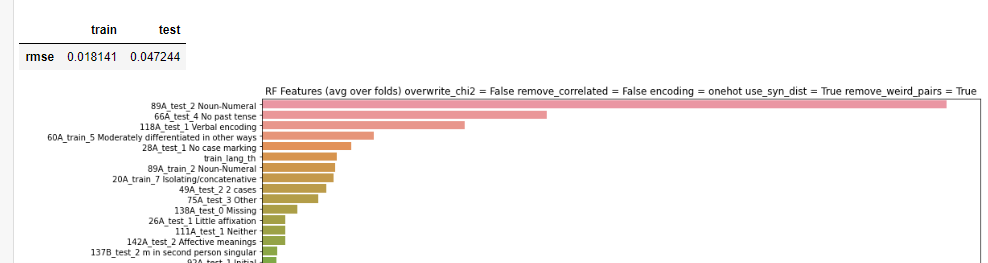

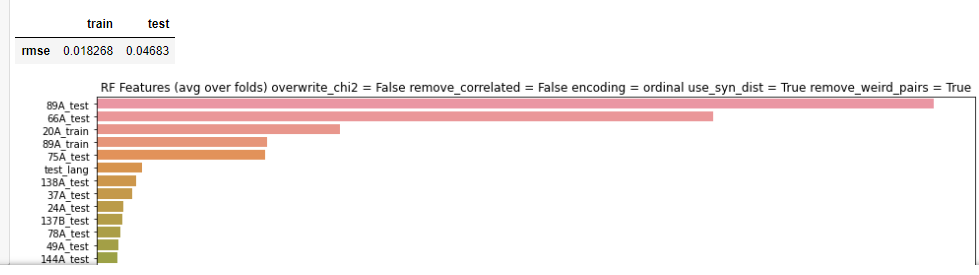

In [41]:
final_df.shape

(855, 321)

XGBoost obtains slightly better results than RF, but the former overfits dramatically.

### Analysing feature importance

In [42]:
final_df.head()

,train_lang,test_lang,acc,f1,20A_train,21A_train,22A_train,23A_train,24A_train,25A_train,26A_train,27A_train,28A_train,29A_train,30A_train,31A_train,32A_train,33A_train,34A_train,35A_train,36A_train,37A_train,38A_train,39A_train,40A_train,41A_train,42A_train,43A_train,44A_train,45A_train,46A_train,47A_train,48A_train,49A_train,50A_train,51A_train,52A_train,53A_train,54A_train,55A_train,56A_train,57A_train,58A_train,59A_train,60A_train,61A_train,62A_train,63A_train,64A_train,65A_train,66A_train,67A_train,68A_train,69A_train,70A_train,71A_train,72A_train,73A_train,74A_train,75A_train,76A_train,77A_train,78A_train,79A_train,80A_train,81A_train,82A_train,83A_train,84A_train,85A_train,86A_train,87A_train,88A_train,89A_train,90A_train,91A_train,92A_train,93A_train,94A_train,95A_train,96A_train,97A_train,98A_train,99A_train,100A_train,101A_train,102A_train,103A_train,104A_train,105A_train,106A_train,107A_train,108A_train,109A_train,110A_train,111A_train,112A_train,113A_train,114A_train,115A_train,116A_train,117A_train,118A_train,119A_train,120A_train,121A_train,122A_train,123A_train,124A_train,125A_train,126A_train,127A_train,128A_train,129A_train,130A_train,131A_train,132A_train,133A_train,134A_train,135A_train,136A_train,137A_train,138A_train,142A_train,143F_train,90B_train,90C_train,144P_train,144J_train,144S_train,144X_train,144A_train,90E_train,144V_train,144I_train,144R_train,144M_train,144G_train,144K_train,144B_train,90D_train,144E_train,144D_train,81B_train,143E_train,143C_train,143A_train,144W_train,144Q_train,144L_train,144H_train,144C_train,144T_train,143G_train,137B_train,136B_train,109B_train,25B_train,21B_train,108B_train,58B_train,79B_train,20A_test,21A_test,22A_test,23A_test,24A_test,25A_test,26A_test,27A_test,28A_test,29A_test,30A_test,31A_test,32A_test,33A_test,34A_test,35A_test,36A_test,37A_test,38A_test,39A_test,40A_test,41A_test,42A_test,43A_test,44A_test,45A_test,46A_test,47A_test,48A_test,49A_test,50A_test,51A_test,52A_test,53A_test,54A_test,55A_test,56A_test,57A_test,58A_test,59A_test,60A_test,61A_test,62A_test,63A_test,64A_test,65A_test,66A_test,67A_test,68A_test,69A_test,70A_test,71A_test,72A_test,73A_test,74A_test,75A_test,76A_test,77A_test,78A_test,79A_test,80A_test,81A_test,82A_test,83A_test,84A_test,85A_test,86A_test,87A_test,88A_test,89A_test,90A_test,91A_test,92A_test,93A_test,94A_test,95A_test,96A_test,97A_test,98A_test,99A_test,100A_test,101A_test,102A_test,103A_test,104A_test,105A_test,106A_test,107A_test,108A_test,109A_test,110A_test,111A_test,112A_test,113A_test,114A_test,115A_test,116A_test,117A_test,118A_test,119A_test,120A_test,121A_test,122A_test,123A_test,124A_test,125A_test,126A_test,127A_test,128A_test,129A_test,130A_test,131A_test,132A_test,133A_test,134A_test,135A_test,136A_test,137A_test,138A_test,142A_test,143F_test,90B_test,90C_test,144P_test,144J_test,144S_test,144X_test,144A_test,90E_test,144V_test,144I_test,144R_test,144M_test,144G_test,144K_test,144B_test,90D_test,144E_test,144D_test,81B_test,143E_test,143C_test,143A_test,144W_test,144Q_test,144L_test,144H_test,144C_test,144T_test,143G_test,137B_test,136B_test,109B_test,25B_test,21B_test,108B_test,58B_test,79B_test,syn_dist
1,0.0,0.0,0.793688,0.546847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.

#### By feature group

In [46]:
groups = {"morphology":list(range(20,30)),
"nom_cat":list(range(30, 58)),
"nom_synt":list(range(58, 65)),
"verb_cat":list(range(65, 81)),
"order":list(range(81, 98))+[143, 144],
"simp_claus":list(range(98, 122)),
"comp_sent":list(range(122, 129)),
"lexicon":list(range(129, 139)),
"other":list(range(141,143)),}


In [47]:
if encoding=="ordinal":
    final_feat_cols = final_df.columns[4:-1]
elif encoding=="onehot":
    final_feat_cols = final_df.columns[56:-1]
else:
    raise Exception("Select proper encoding.")

Group morphology
Model type rf

Mean fold metrics


,train,test
rmse,0.042118,0.06305


Group nom_cat
Model type rf

Mean fold metrics


,train,test
rmse,0.019333,0.050832


Group nom_synt
Model type rf

Mean fold metrics


,train,test
rmse,0.040094,0.065175


Group verb_cat
Model type rf

Mean fold metrics


,train,test
rmse,0.022517,0.059325


Group order
Model type rf

Mean fold metrics


,train,test
rmse,0.021429,0.048715


Group simp_claus
Model type rf

Mean fold metrics


,train,test
rmse,0.02077,0.053402


Group comp_sent
Model type rf

Mean fold metrics


,train,test
rmse,0.047359,0.068456


Group lexicon
Model type rf

Mean fold metrics


,train,test
rmse,0.032382,0.059869


Group other
Model type rf

Mean fold metrics


,train,test
rmse,0.119234,0.120407


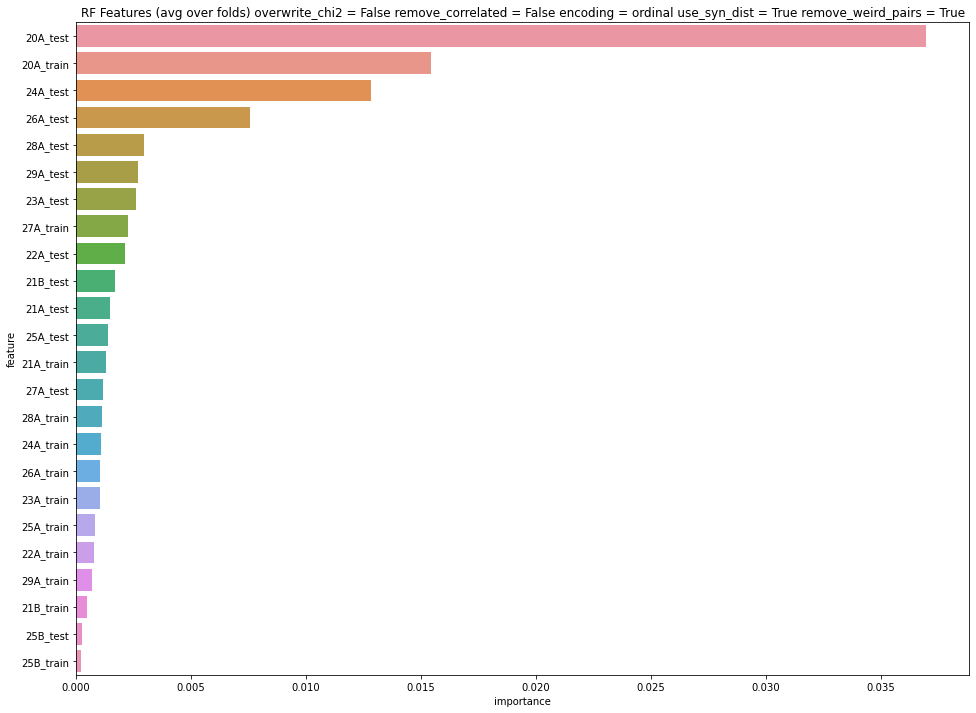

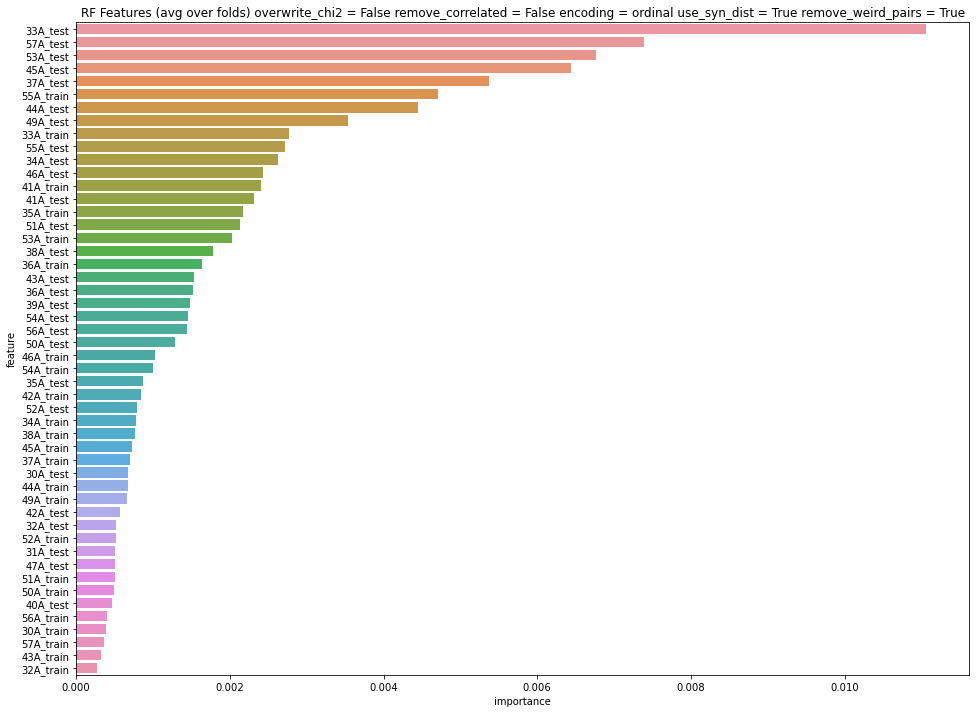

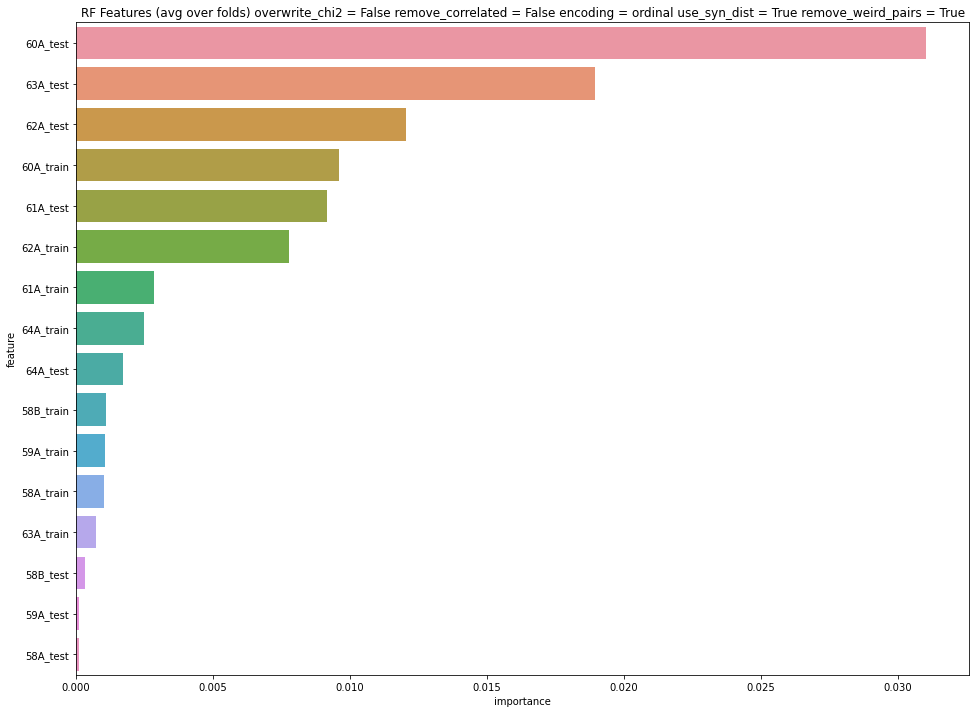

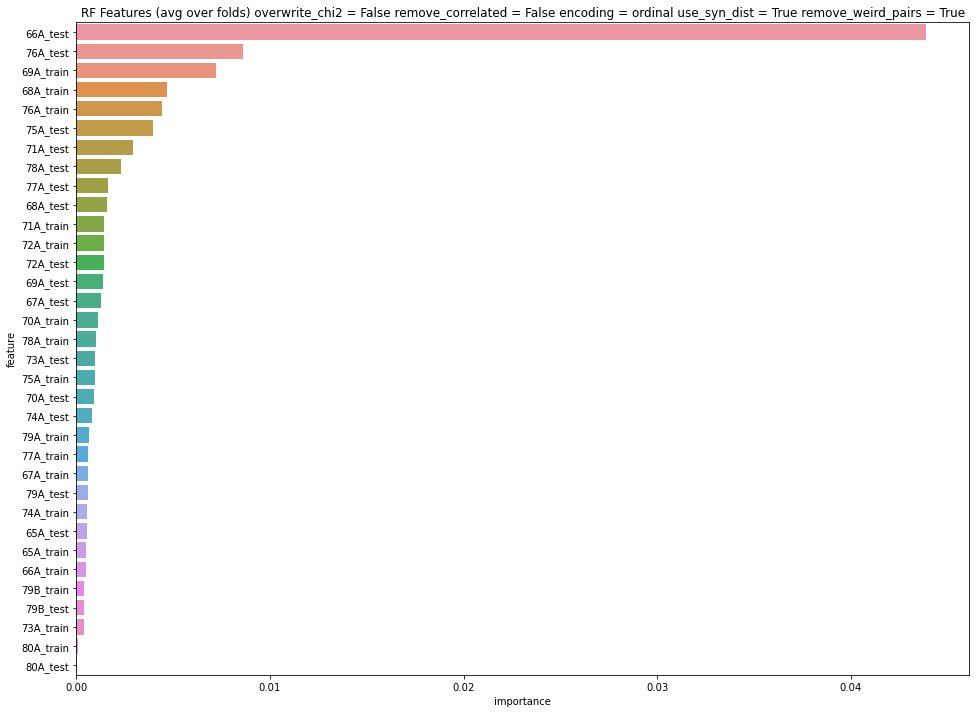

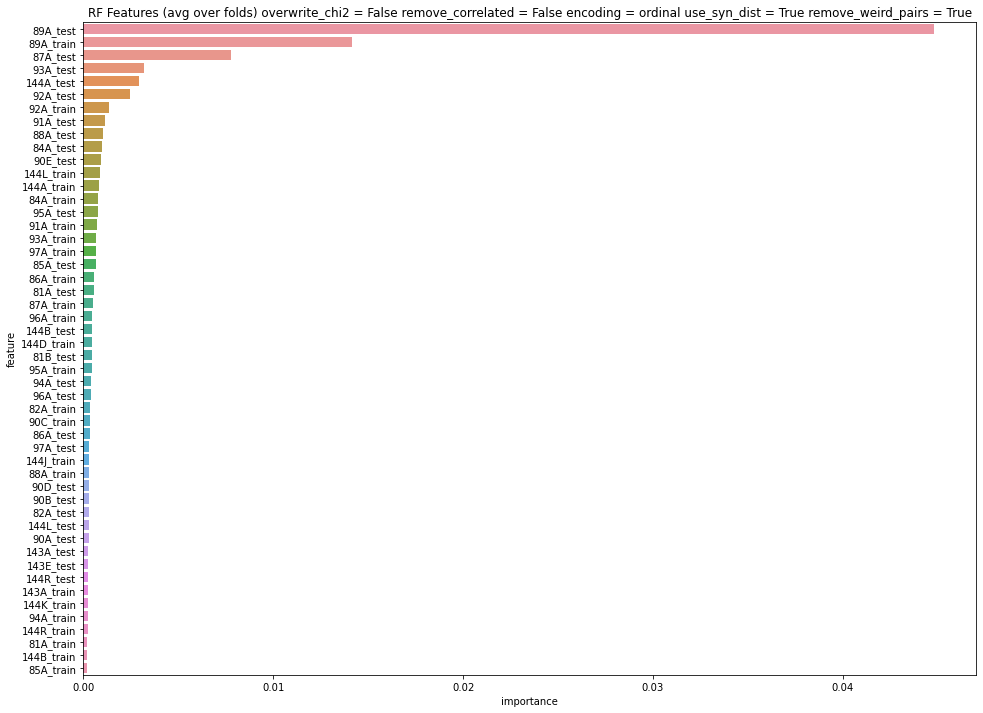

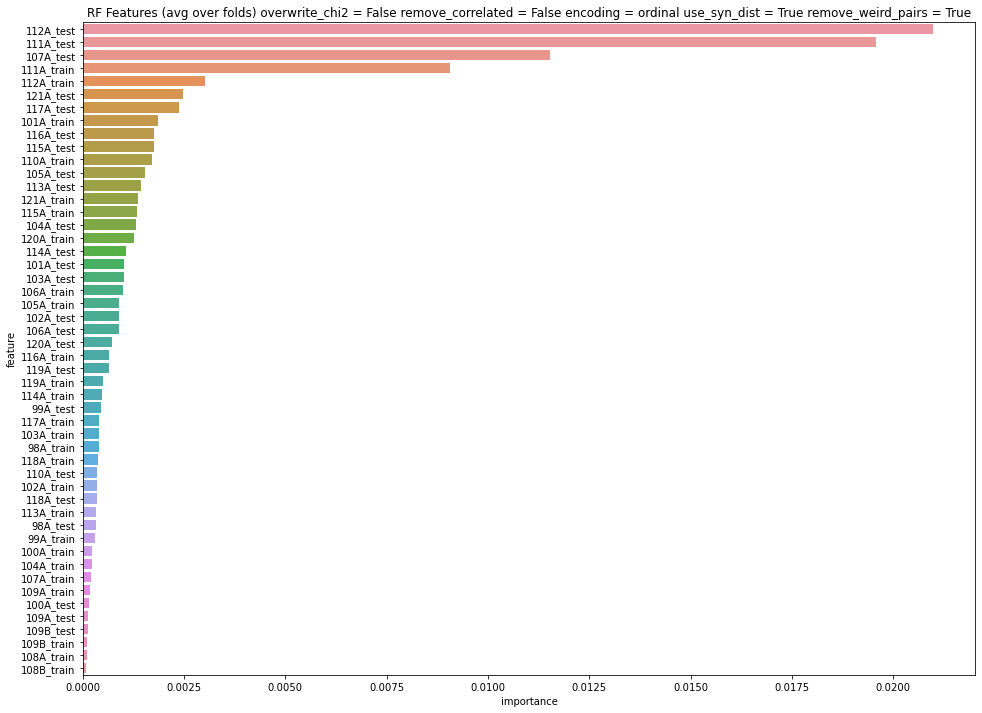

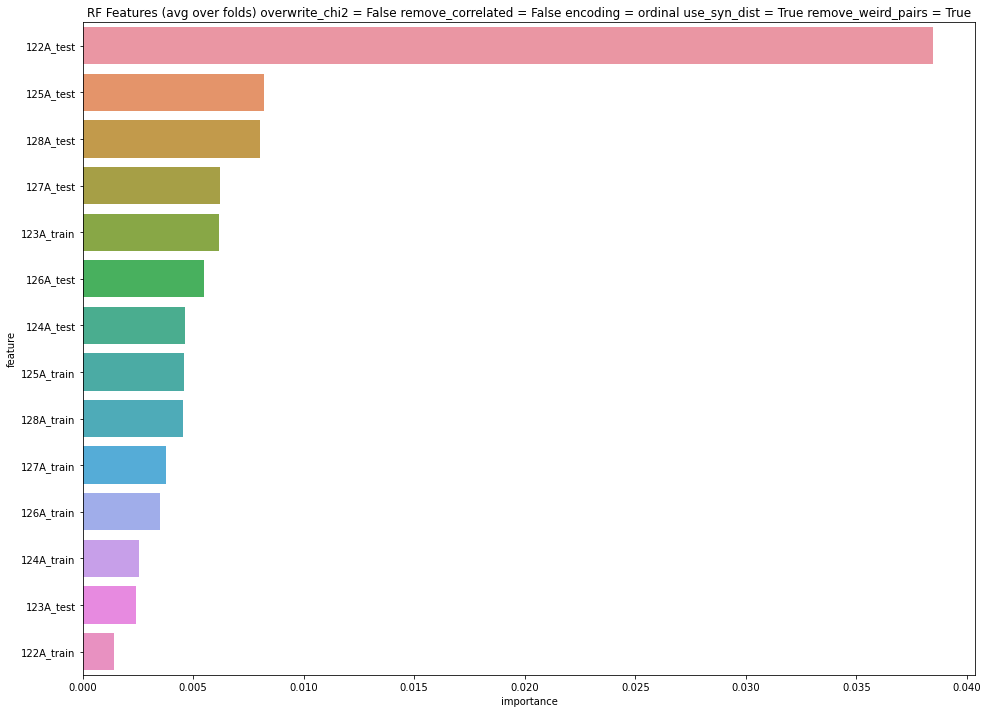

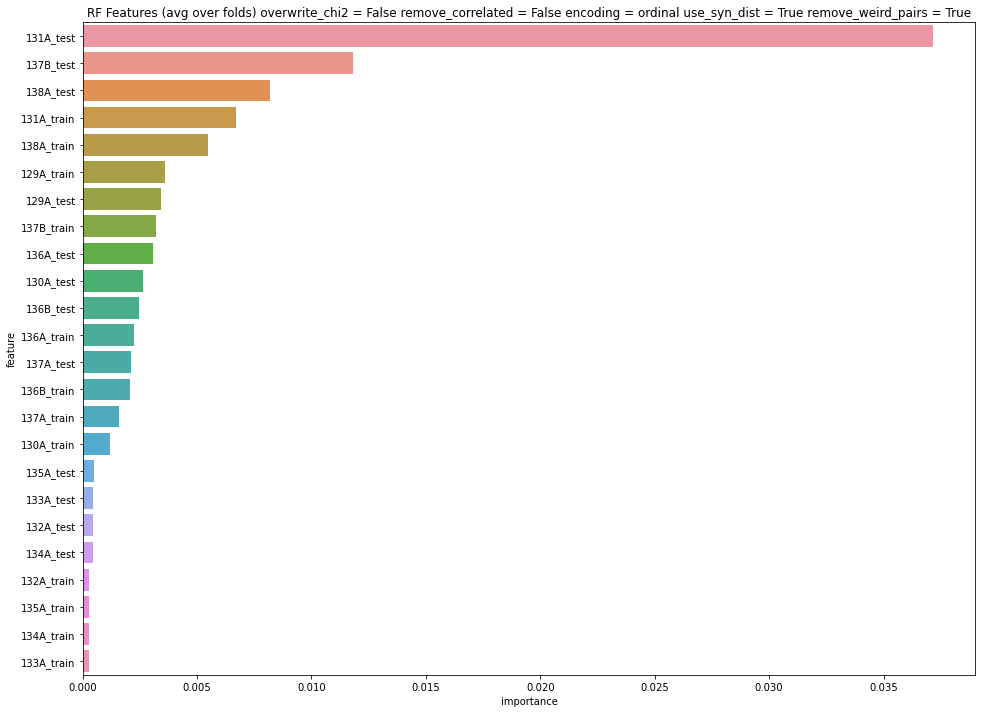

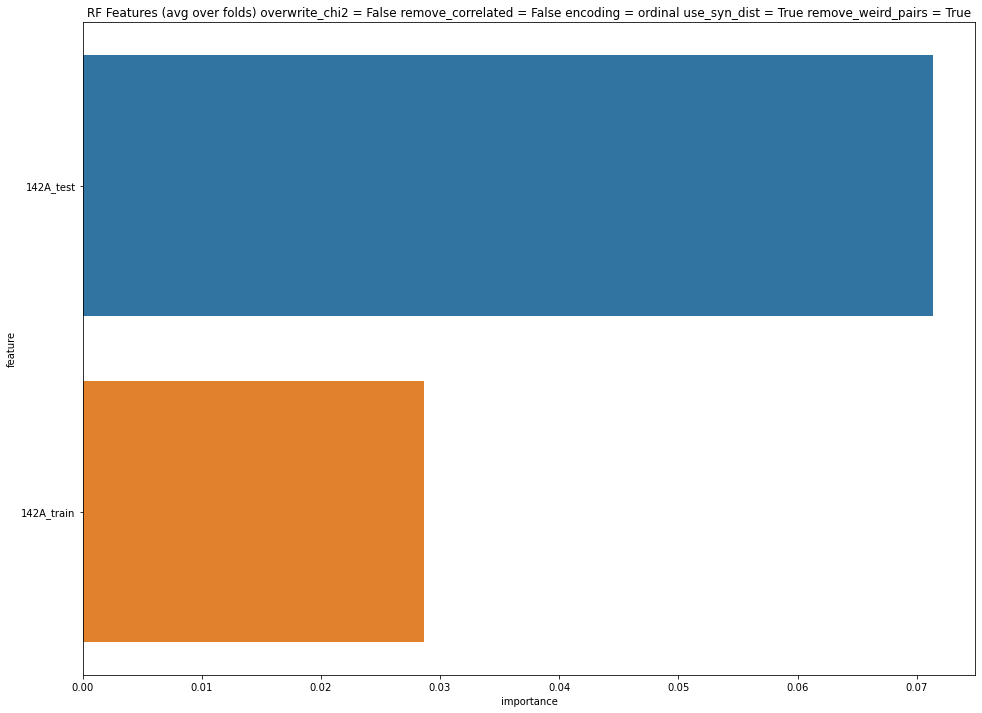

In [48]:

areas = []
metrics = []
for area in groups:
    group_range = groups[area]
    group_cols = [col for col in final_feat_cols if int(re.match("\d*", col).group()) in group_range]
    print("Group",area)
#     print("Cols",group_cols)
    X = final_df[group_cols]
    y = final_df['acc']
    results, model = train_model(X,y,folds,params=None,model_type='rf')
    areas.append(area)
    metrics.append(results['metrics'])

In [49]:
group_results = pd.concat(metrics)
group_results["group"] = areas

In [50]:
group_results.sort_values(by="test")

,train,test,group
rmse,0.021429,0.048715,order
rmse,0.019333,0.050832,nom_cat
rmse,0.020770,0.053402,simp_claus
rmse,0.022517,0.059325,verb_cat
rmse,0.032382,0.059869,lexicon
rmse,0.042118,0.063050,morphology
rmse,0.040094,0.065175,nom_synt
rmse,0.047359,0.068456,comp_sent
rmse,0.119234,0.120407,other


### Comparing to syntactical distance

#### Predict just with word order and syn_dist

Model type rf

Mean fold metrics


,train,test
rmse,0.018776,0.0468


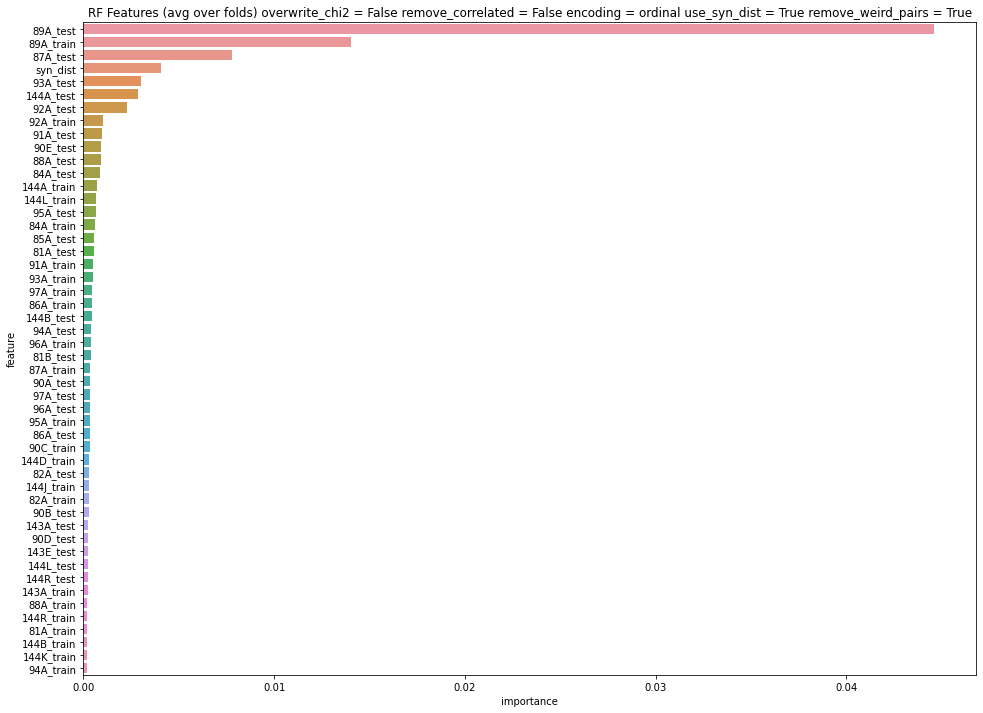

In [51]:
order_cols = [col for col in final_feat_cols if int(re.match("\d*", col).group()) in groups["order"]]
X = final_df[order_cols+["syn_dist"]]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

#### Predict with all features and syntactical distance

Model type rf

Mean fold metrics


,train,test
rmse,0.018395,0.047466


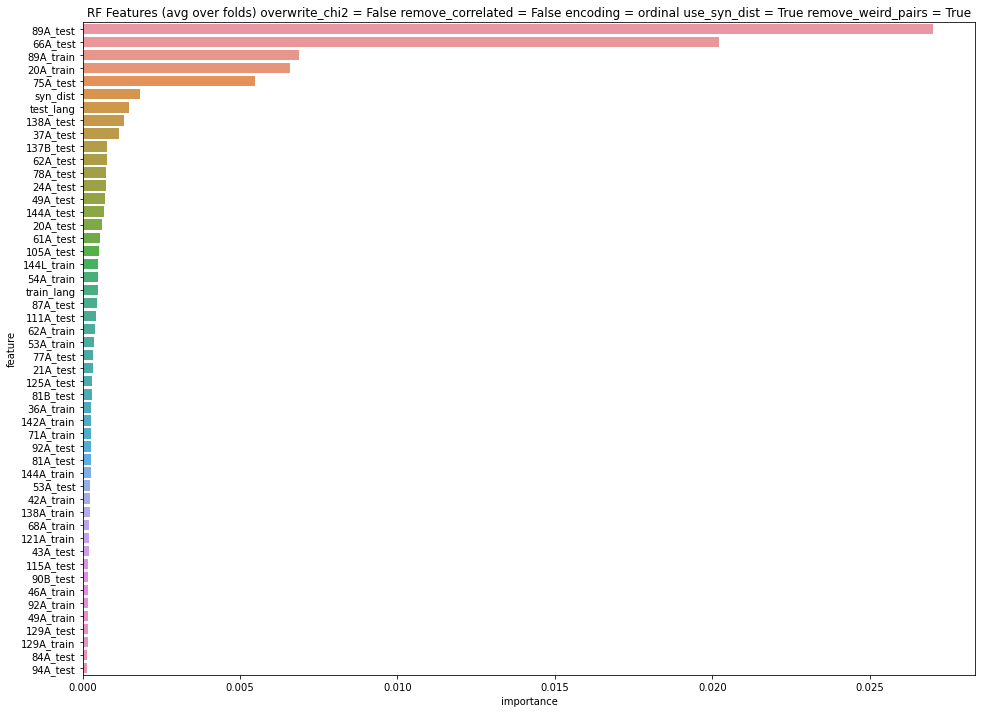

In [52]:
X = final_df.drop(['acc','f1'],axis=1)
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

#### Predict with only syntactical distance

In [56]:
final_df = final_df[final_df.syn_dist!=-1]

In [57]:
X = final_df[['syn_dist']]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='linear',plot_feature_importance=False)

Model type linear

Mean fold metrics


,train,test
rmse,0.123371,0.122816


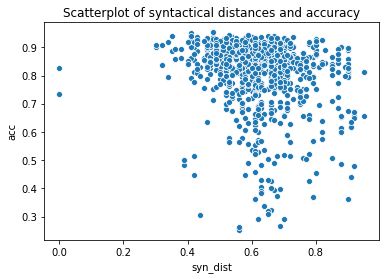

In [58]:
sns.scatterplot(x='syn_dist',y='acc',data=final_df)
plt.title("Scatterplot of syntactical distances and accuracy")
plt.show()

Pearson correlation between accuracy and syntactical distance

In [59]:
from scipy import stats

stats.pearsonr(final_df['acc'], final_df['syn_dist'])

(-0.20481072764355296, 1.5018412642810512e-09)

### Predicting only with "A" features

Model type rf

Mean fold metrics


,train,test
rmse,0.018436,0.047531


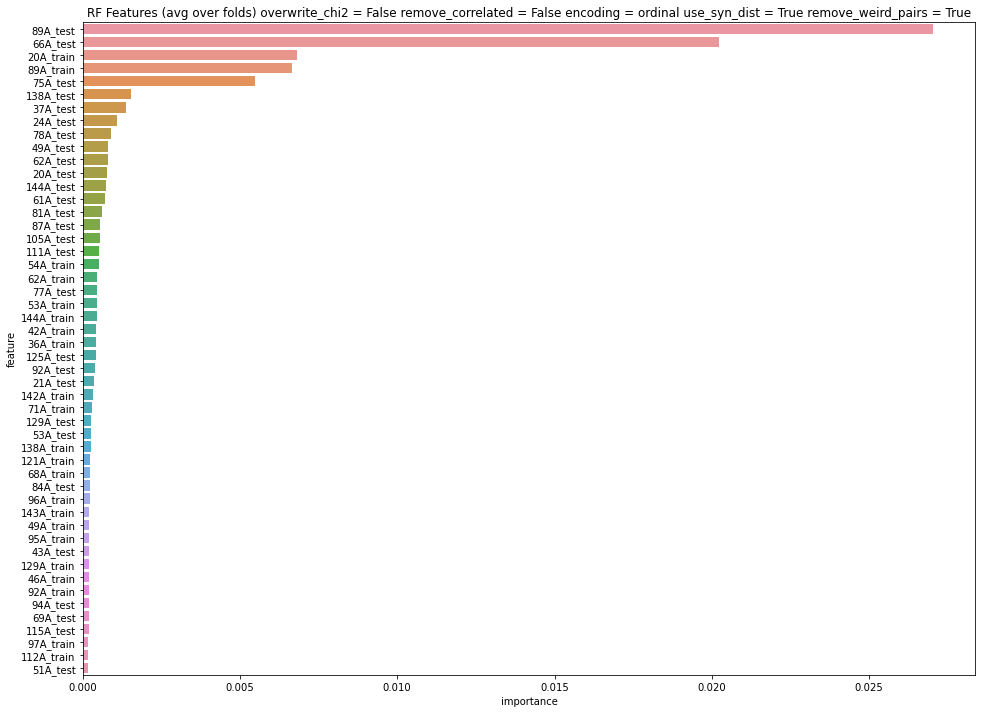

In [60]:
a_feats = [col for col in final_feat_cols if col.split("_")[0][-1]=="A"]

X = final_df[a_feats]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')

### Predicting only with WBO features 

Model type rf

Mean fold metrics


,train,test
rmse,0.046675,0.06258


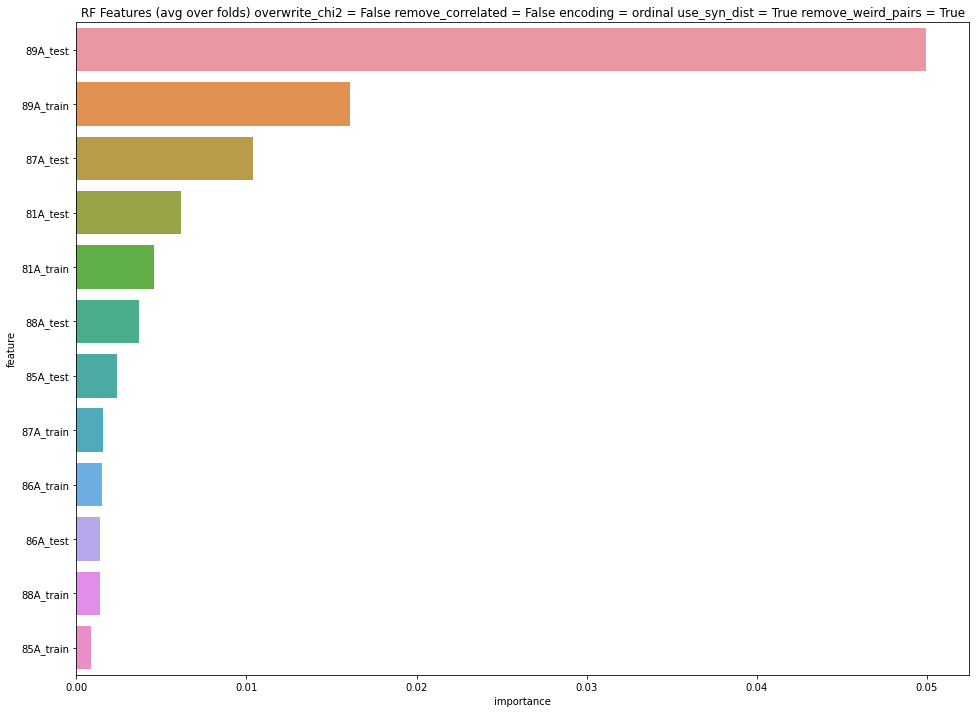

In [61]:
wbo = ['81A Order of Subject, Object and Verb',
'85A Order of Adposition and Noun Phrase',
'86A Order of Genitive and Noun',
'87A Order of Adjective and Noun',
'88A Order of Demonstrative and Noun',
'89A Order of Numeral and Noun']

wbo_cols = [col.split()[0]+"_train" for col in wbo]+ [col.split()[0]+"_test" for col in wbo]

X = final_df[wbo_cols]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='rf')